In [ ]:
pip install keras tensorflow

In [ ]:
import tensorflow as tf
print(tf.keras.__version__)

3.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

dataset_path = '/content/drive/MyDrive/ai ml/DevanagariHandwrittenDigitDataset'

# Load dataset
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(28, 28),
    color_mode='grayscale',
    batch_size=32
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(28, 28),
    color_mode='grayscale',
    batch_size=32
)


Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


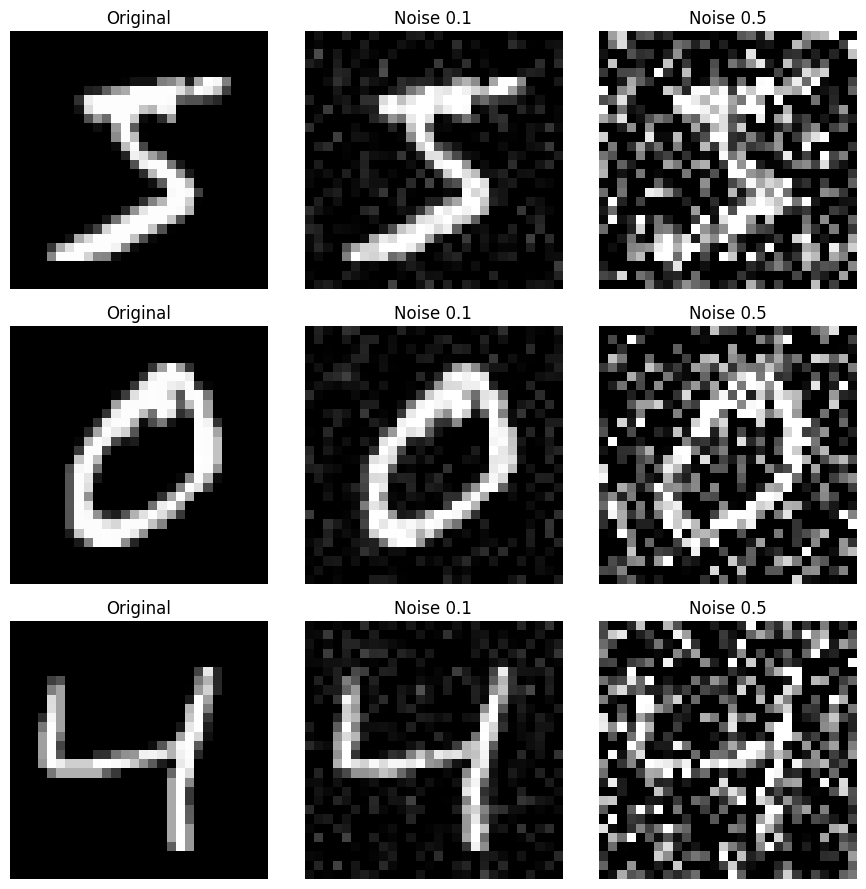

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5

x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

# Visualize in a 3 x 3 grid
n = 3  # number of samples to show
plt.figure(figsize=(9, 9))
for i in range(n):
    # Original image
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Low noise image
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    # High noise image
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_encoder(input_shape=(28, 28, 1)):
    """
    Builds the encoder part of the convolutional autoencoder.

    Parameters:
        input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.

    Returns:
        input_img (Keras Input): Input layer of the model.
        encoded (Keras Tensor): Encoded representation after convolution and pooling.
    """
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    return input_img, encoded


def build_decoder(encoded_input):
    """
    Builds the decoder part of the convolutional autoencoder.

    Parameters:
        encoded_input (Keras Tensor): The output from the encoder.

    Returns:
        decoded (Keras Tensor): The reconstructed output after upsampling and convolution.
    """
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Build encoder and decoder
input_img, encoded = build_encoder()
decoded = build_decoder(encoded)



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder():
    """
    Constructs and compiles the full convolutional autoencoder by connecting encoder and decoder.

    Returns:
        autoencoder (Keras Model): Compiled autoencoder model.
    """
    input_img, encoded_output = build_encoder()
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")

    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

    return autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (MaxPooling2D)          │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoded (Conv2D)                │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = autoencoder.fit(
    x_train_noisy_low, x_train,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_low, x_test)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 191s 402ms/step - loss: 0.1931 - val_loss: 0.0767
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 391ms/step - loss: 0.0763 - val_loss: 0.0723
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 385ms/step - loss: 0.0727 - val_loss: 0.0709
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 392ms/step - loss: 0.0710 - val_loss: 0.0696
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 181s 386ms/step - loss: 0.0699 - val_loss: 0.0688
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 382ms/step - loss: 0.0694 - val_loss: 0.0682
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 385ms/step - loss: 0.0686 - val_loss: 0.0678
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 385ms/step - loss: 0.0681 - val_loss: 0.0674
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 174s 371ms/step - loss: 0.0677 - val_loss: 0.0672
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 205s 379ms/step - loss: 0.0675 - val_loss: 0.0668
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 378ms/step - loss: 0.0673 - val_loss: 0.0669
Epoch 12

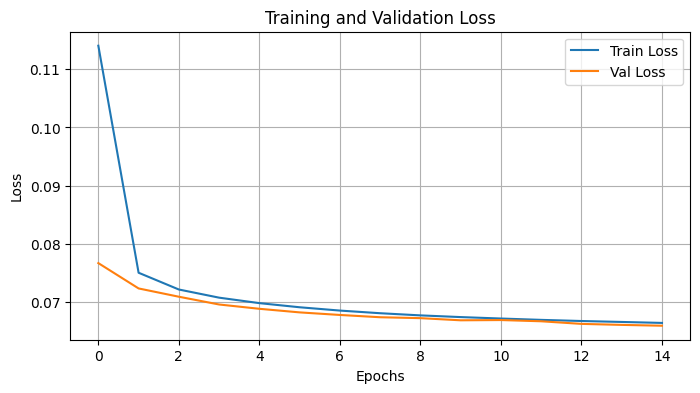

In [13]:
# Plot loss curves
def plot_training_history(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title("Training and Validation Loss")
    plt.show()

plot_training_history(history)